<a href="https://colab.research.google.com/github/Jarcos09/Tareas/blob/main/Visualizaci%C3%B3n_Equipo_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 **Inteligencia Artificial Aplicada**

## 🤖 **Análisis de grandes volúmenes de datos (Gpo 10)**

### 🏛️ Tecnológico de Monterrey

#### 👨‍🏫 **Profesor titular :** Dr. Iván Olmos Pineda
#### 👩‍🏫 **Profesor asistente :** Verónica Sandra Guzmán de Valle

### 📊 **Actividad 5 | Visualización de Resultados**

#### 📅 **15 de junio de 2025**

### 👥 Equipo 29

* 🧑‍💻 **A01795941 :** Juan Carlos Pérez Nava
* 🧑‍💻 **A01016093 :** Oscar Enrique García García
* 🧑‍💻 **A01795164 :** Oscar Andrés Ponce Parra




In [1]:
# Módulos del sistema para manejo de rutas
import os
import sys

# 🔧 Definición del path para incluir una librería personalizada
# Se establece la ruta donde están almacenadas las librerías adicionales que se usarán en el proyecto.
module_path = os.path.abspath(os.path.join('proyectos/librerias'))
if module_path not in sys.path:
    sys.path.append(module_path)

# 🎨 Importación de módulos gráficos personalizados
# Se usa un módulo externo 'graficas' que contiene funciones para el calculo del IQR
from graficas import *

# 🏗️ Definición de estructuras de datos en PySpark
# Se importan los tipos de datos que se pueden utilizar en las tablas (DataFrame).
from pyspark.sql import (
    SparkSession, DataFrame
)

# 🏛️ Funciones SQL de PySpark para manipulación de datos
# Estas funciones permiten realizar operaciones como filtrado, agregación y transformación de datos.
from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType, DoubleType
)

# 🚀 Transformaciones de datos con PySpark ML
# Se importan herramientas para preprocesamiento, ingeniería de características y normalización.
from pyspark.sql.functions import (
    col, sum, avg, lit, count, when, format_number, round, rand, countDistinct,
    concat
)

# 🚀 Transformaciones de datos con PySpark ML
# Se importan herramientas para preprocesamiento, ingeniería de características y normalización.
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, QuantileDiscretizer,
    VectorAssembler, StandardScaler, Imputer
)

# 📝 Fórmula para modelado en ML usando RFormula
# Simplifica la transformación de variables predictoras y objetivos en un solo paso.
from pyspark.ml.feature import RFormula

# 🌲 Importación del modelo RandomForestClassifier
from pyspark.ml.classification import RandomForestClassifier

# 🔎 Importación de K-Means para clustering
from pyspark.ml.clustering import KMeans

# 📊 Evaluación de modelos de Machine Learning
# Se importan métricas para evaluar la calidad de los modelos supervisados y no supervisados.
from pyspark.ml.evaluation import(    MulticlassClassificationEvaluator, ClusteringEvaluator
    )

# 🔄 Optimización de modelos mediante validación cruzada y búsqueda de hiperparámetros
from pyspark.ml.tuning import (
    ParamGridBuilder, CrossValidator
)

# 🎨 Importación de librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# 📦 Librería para la integración con Kaggle
import kagglehub

# 🏗️ Manipulación de datos con Pandas
import pandas as pd

# 🔄 Funciones de programación funcional en Python
# 'reduce' permite realizar operaciones acumulativas en estructuras de datos iterables.
from functools import reduce

In [2]:
path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
print("Path to dataset files:", path)

Path to dataset files: /home/jarcos/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13


In [3]:
# Creación de una sesión de Spark
# Se configura el modo "local[*]" para usar todos los núcleos disponibles en la máquina
# Se asigna un nombre a la aplicación y se configuran los límites de memoria para el driver y los ejecutores

spark = SparkSession.builder.master("local[*]").appName("metricas").config("spark.driver.memory", "40g").config("spark.executor.memory", "20g").getOrCreate()
df_accident = spark.read.option("header", True).option("inferSchema", True).csv(path)
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/09 21:17:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# **1 - Definición de Validación Cruzada**

**Etapa 1: Feature Engineering**

A lo largo de las actividades, se han realizado particiones considerando, en primer lugar, la severidad del accidente y, posteriormente, las condiciones climáticas. En este ejercicio se analizará la frecuencia de dichas particiones para identificar combinaciones que permitan una distribución homogénea. Por ello, se revisará el estado actual de estos subconjuntos.


In [4]:
# Definición de las columnas clave que serán utilizadas para el análisis y particionamiento
columnas_clave = ["Temperature(F)","Weather_Condition","Severity","Humidity(%)",
                  "Pressure(in)", "Wind_Direction","Wind_Speed(mph)","Precipitation(in)",
                  "Crossing","Junction","Railway","Roundabout","Stop","Sunrise_Sunset",
                  "Traffic_Calming","Traffic_Signal"]

# Escritura del DataFrame en formato Parquet, particionando por las columnas "Severity" y "Weather_Condition"
df_particionada = df_accident.select(columnas_clave)
df_particionada.write.mode("overwrite").partitionBy("Severity","Weather_Condition").parquet("us_accidents_partitioned")

Para generar una partición homogénea con una cantidad significativa de registros, se propone excluir las severidades 1 y 4, ya que representan menos del 1% y 2% del conjunto total, respectivamente. Posteriormente, se seleccionan las condiciones climáticas más predominantes en los accidentes de las severidades restantes, tomando 10,000 registros de cada una, con el objetivo de garantizar condiciones uniformes en cada partición.

In [5]:
# Definir la cantidad de registros a tomar por cada condición climática
registros = {
    "Fair": 10000,
    "Clear": 10000,
    "Mostly Cloudy": 10000,
    "Cloudy": 10000,
    "Partly Cloudy": 10000,
    "Overcast": 10000,
    "Light Rain": 10000
}

# Obtener la lista de condiciones climáticas disponibles en el diccionario de registros
weather_conditions = list(registros.keys())

# Definir las severidades de interés
severidades = [{'Severity': 2}, {'Severity': 3}]

# Crear un diccionario para almacenar los DataFrames filtrados y limitados
dfs = {}

# Generar un DataFrame por cada valor de severidad con el filtro y límite de condiciones climáticas
for severidad in severidades:

    clave = f"Severity_{severidad['Severity']}"

    # Filtrar el DataFrame para mantener solo las filas con la severidad actual y las condiciones climáticas definidas
    df_filtrado = df_particionada.filter(
        (df_particionada["Severity"] == severidad["Severity"]) &
        (df_particionada["Weather_Condition"].isin(weather_conditions))
    )

    # Aplicar el límite de registros por cada condición climática
    df_limitado = df_filtrado.groupBy("Weather_Condition").applyInPandas(
        lambda pdf: pdf.iloc[:registros.get(pdf.iloc[0]["Weather_Condition"], len(pdf))],  # Selecciona hasta 10,000 registros por condición
        schema=df_filtrado.schema  # Mantiene la estructura original del DataFrame
    )

    # Guardar el DataFrame filtrado y limitado en el diccionario
    dfs[clave] = df_limitado

# Obtener las claves generadas en el diccionario de DataFrames
claves = dfs.keys()

In [6]:
# Unir todos los DataFrames en uno solo
df_muestra = reduce(DataFrame.unionAll, dfs.values())

# Contar registros totales para verificar
print(f"Total de registros en el DataFrame final: \033[36m{df_muestra.count()}\033[0m")

Total de registros en el DataFrame final: 140000


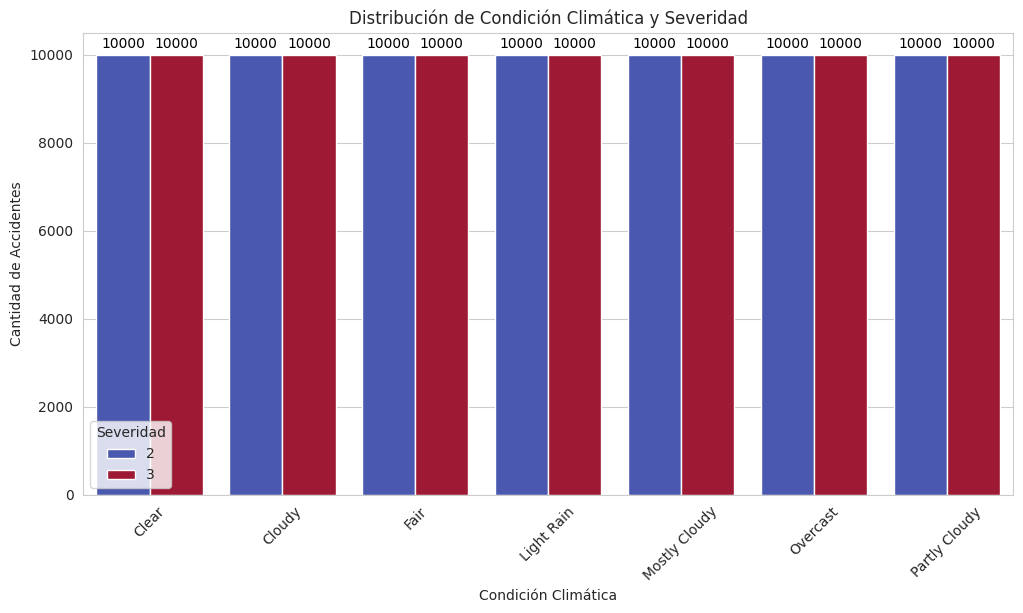

In [7]:
# Convertir a Pandas DataFrame
muestra_pd = df_muestra.select("Severity", "Weather_Condition").toPandas()

# Configuración de estilo
sns.set_style("whitegrid")

# Crear la tabla de frecuencia
tabla_frecuencia = muestra_pd.groupby(["Weather_Condition", "Severity"]).size().reset_index(name="Count")

# Crear el gráfico
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Weather_Condition", y="Count", hue="Severity", data=tabla_frecuencia, palette="coolwarm")

# Agregar los valores en cada barra
for bars in ax.containers:
    ax.bar_label(bars, fmt='%d', label_type='edge', fontsize=10, color='black', padding=3)

# Configurar etiquetas y título
plt.xticks(rotation=45)
plt.xlabel("Condición Climática")
plt.ylabel("Cantidad de Accidentes")
plt.title("Distribución de Condición Climática y Severidad")

# Ajustar la leyenda
plt.legend(title="Severidad")

# Mostrar el gráfico
plt.show()


**Etapa 2: Procesamiento y Limpieza del Conjunto de Datos**


In [8]:
# Función para obtener un resumen de valores nulos en un DataFrame de PySpark
def obten_nulos(particion):

  print(f"📊 Total de filas en la partición: \033[36m{particion.count()}\033[0m")
  print(f"🗂️ Número de columnas en la partición: \033[36m{len(particion.columns)}\033[0m")

  info_nulos = {}
  cols_nulos = {}
  total_rows = particion.count()
  registros_totales = particion.count()

  # Contar valores nulos por columna y almacenarlos en un DataFrame temporal

  cols_nulos = particion.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in particion.columns]
    )

  # Convertir los resultados en un diccionario para fácil acceso
  info_nulos = {c: cols_nulos.select(c).collect()[0][0] for c in particion.columns}

  # Filtrar solo las columnas con valores nulos y calcular el porcentaje de nulos
  cols_nulos = {c: {"count": v, "percent": (v / total_rows) * 100} for c, v in info_nulos.items() if v > 0}

  # Validar si existen columnas con valores nulos
  if not cols_nulos:
        print("✅ No existen valores nulos en la partición.")
        return

  # Crear una lista con los resultados para construir un DataFrame
  listado = [(key, value['count'], value['percent']) for key, value in cols_nulos.items()]

  # Definir el esquema del DataFrame para almacenar el resumen de valores nulos
  schema = StructType([
    StructField("Columna", StringType(), True),
    StructField("Total de nulos", IntegerType(), True),
    StructField("Porcentaje", DoubleType(), True)
  ])

  df_resumen_nulos = spark.createDataFrame(listado, schema=schema)

  for col_name in [c for c, t in df_resumen_nulos.dtypes if t == "double"]:
      df_resumen_nulos = df_resumen_nulos.withColumn(col_name, round(df_resumen_nulos[col_name], 2))

  # Ordenar el DataFrame por el número de valores nulos en orden descendente y mostrarlo en consola
  df_resumen_nulos.orderBy(col("Total de nulos").desc()).show(truncate=False)

In [9]:
# Función para imputar valores faltantes en una partición del conjunto de datos
def imputacion_valores(particion):
    print("✅ Se realiza la imputación utilizando los siguientes valores:\n")

    # Obtener las modas (valores más frecuentes) de las variables categóricas
    moda_Weather = particion.groupBy("Weather_Condition").count().orderBy(col("count").desc()).first()["Weather_Condition"]
    moda_wub = particion.groupBy("Wind_Direction").count().orderBy(col("count").desc()).first()["Wind_Direction"]
    moda_Sunset = particion.groupBy("Sunrise_Sunset").count().orderBy(col("count").desc()).first()["Sunrise_Sunset"]

    # Obtener promedios de las variables numéricas para imputación
    media_Temperature = particion.select(round(avg(col("Temperature(F)")), 2).alias("avg_temp")).collect()[0][0]
    media_Humidity = particion.select(round(avg(col("Humidity(%)")), 2).alias("avg_humidity")).collect()[0][0]
    media_Precipitation = particion.select(round(avg(col("Precipitation(in)")), 2).alias("avg_precipitation")).collect()[0][0]
    media_Pressure = particion.select(round(avg(col("Pressure(in)")), 2).alias("Pressure(in)")).collect()[0][0]
    media_Wind_Speed = particion.select(round(avg(col("Wind_Speed(mph)")), 2).alias("Wind_Speed(mph)")).collect()[0][0]

    # Imprimir valores calculados correctamente
    print(f"🌡️ Temperatura promedio: \033[36m{media_Temperature}\033[0m")
    print(f"💧 Humedad promedio: \033[36m{media_Humidity}\033[0m")
    print(f"🌧️ Precipitación promedio: \033[36m{media_Precipitation}\033[0m")
    print(f"🌬️ Velocidad del viento promedio: \033[36m{media_Wind_Speed}\033[0m")

    print(f"☁️ Condición meteorológica más frecuente: \033[36m{moda_Weather}\033[0m")
    print(f"🌬️ Dirección del viento más frecuente: \033[36m{moda_wub}\033[0m")
    print(f"🌅 Hora de atardecer más frecuente: \033[36m{moda_Sunset}\033[0m")

    # Aplicar imputación de valores numéricos con la estrategia de promedio
    imputer_num = Imputer(
         inputCols=["Temperature(F)", "Humidity(%)", "Precipitation(in)", "Wind_Speed(mph)","Pressure(in)"],
         outputCols=["Temperature(F)", "Humidity(%)", "Precipitation(in)", "Wind_Speed(mph)","Pressure(in)"]
    ).setStrategy("mean")

    particion = imputer_num.fit(particion).transform(particion)

    # Imputación de valores categóricos utilizando la moda
    particion = particion.na.fill({
        "Weather_Condition": moda_Weather,
        "Wind_Direction": moda_wub,
        "Sunrise_Sunset": moda_Sunset
    })

    print("\n🔍 Se validan nuevamente los valores nulos para corroborar la imputación.\n")

    obten_nulos(particion)

    for col_name in [c for c, t in particion.dtypes if t == "double"]:
      particion = particion.withColumn(col_name, round(particion[col_name], 1))

    return particion

In [10]:
muestra_imp = imputacion_valores(df_muestra)

✅ Se realiza la imputación utilizando los siguientes valores:



🌡️ Temperatura promedio: 65.22
💧 Humedad promedio: 69.46
🌧️ Precipitación promedio: 0.01
🌬️ Velocidad del viento promedio: 8.15
☁️ Condición meteorológica más frecuente: Cloudy
🌬️ Dirección del viento más frecuente: Calm
🌅 Hora de atardecer más frecuente: Day



🔍 Se validan nuevamente los valores nulos para corroborar la imputación.



📊 Total de filas en la partición: 140000
🗂️ Número de columnas en la partición: 16


✅ No existen valores nulos en la partición.


Para detectar valores atípicos en las columnas numéricas seleccionadas, se utiliza el método del rango intercuartílico (IQR), que permite identificar aquellos valores que se desvían del rango esperado en cada columna.

In [11]:
outliers = calcular_IQR(muestra_imp,['Precipitation(in)','Temperature(F)','Humidity(%)','Wind_Speed(mph)','Pressure(in)'])
outliers

,IQR,Límite Inf.,Límite Sup.
Columna,,,
Precipitation(in),0.0,0.00,0.00
Temperature(F),20.0,25.90,105.90
Humidity(%),30.0,11.00,131.00
Wind_Speed(mph),5.4,-3.10,18.50
Pressure(in),0.3,29.35,30.55


In [12]:
for index, row in outliers.iterrows():
    columna = index
    limite_inf = row["Límite Inf."]
    limite_sup = row["Límite Sup."]

    columnas_IQR = f"`{columna}`"

    # Aplicar una transformación a la columna para reemplazar valores atípicos
    # Si un valor está fuera de los límites establecidos, se sustituye por el promedio de la columna
    # En caso contrario, se conserva el valor original
    muestra_imp = muestra_imp.withColumn(columna, when((col(columna) < limite_inf) | (col(columna) > limite_sup), muestra_imp.selectExpr(f"avg({columnas_IQR})").collect()[0][0])
        .otherwise(col(columna))
    )


Se imprime un resumen de las estadísticas descriptivas de los valores numéricos, proporcionando métricas clave para su verficacion.

In [13]:
muestra_imp.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+--------------+------------------+--------------------+--------------+
|summary|    Temperature(F)|Weather_Condition|          Severity|       Humidity(%)|      Pressure(in)|Wind_Direction|   Wind_Speed(mph)|   Precipitation(in)|Sunrise_Sunset|
+-------+------------------+-----------------+------------------+------------------+------------------+--------------+------------------+--------------------+--------------+
|  count|            140000|           140000|            140000|            140000|            140000|        140000|            140000|              140000|        140000|
|   mean| 65.79846440924454|             NULL|               2.5| 69.63205350112243|29.937271497784945|          NULL| 7.859640492423623|1.688425306122476E-4|          NULL|
| stddev|14.371687150802224|             NULL|0.5000017857238522|20.563527846658314|0.1915637539781627|          NULL|3.8651214279

**Etapa 3: Generación de Vectores de Características**

Se crea el vector de características utilizando RFormula, que permite transformar los datos de manera estructurada para su uso en modelos de aprendizaje automático.

In [14]:
# "Severity ~ ." indica que 'Severity' es la variable dependiente y el resto son predictoras
rForm = RFormula(formula="Severity ~ .")

# Ajustar el modelo RFormula al DataFrame de entrada
muestra_RF = rForm.fit(muestra_imp)

# Transformar el DataFrame para preparar los datos según la fórmula aplicada
muestra_preparadaRF = muestra_RF.transform(muestra_imp)

# Mostrar las primeras 5 filas del DataFrame transformado
muestra_preparadaRF.show(5)

+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|      Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Crossing|Junction|Railway|Roundabout| Stop|Sunrise_Sunset|Traffic_Calming|Traffic_Signal|            features|label|
+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+
|          49.0|           Cloudy|       2|      100.0|29.801319285714076|             E|           10.0|              0.0|   false|   false|  false|     false|false|           Day|          false|         false|(42,[0,2,7,8,32,3...|  2.0|
|          63.0|           Cloudy|      

In [15]:
muestra_preparadaRF.printSchema()

root
 |-- Temperature(F): double (nullable = true)
 |-- Weather_Condition: string (nullable = false)
 |-- Severity: integer (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Wind_Direction: string (nullable = false)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Roundabout: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 |-- Sunrise_Sunset: string (nullable = false)
 |-- Traffic_Calming: boolean (nullable = true)
 |-- Traffic_Signal: boolean (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)



**Etapa 4: Creación de Conjuntos de Entrenamiento y Prueba**

In [16]:
print(f"Número de registros: \033[36m{muestra_preparadaRF.count():,}\033[0m")

Número de registros: 140,000


**Muestreo estratificado**

 El muestreo estratificado es una técnica de selección de datos donde se agrupan las observaciones en estratos antes de extraer una muestra representativa de cada uno, siendo util para:

✅**Garantiza representatividad**: Cada condición climática y nivel de severidad tendrá una proporción similar en la muestra.

✅**Evita sesgos**: Permite que todas las categorías del dataset estén bien representadas.

✅**Mejora la calidad del modelo**: Si las clases están desbalanceadas, esto ayuda a equilibrarlas antes del entrenamiento.


In [17]:
# 🔧 Crear una nueva columna llamada 'stratum'
# Combina la condición climática y la severidad, separadas por un guion bajo ("_")
# Esto ayuda a generar una categoría compuesta útil para análisis estratificados

muestra_preparadaRF_stratum = muestra_preparadaRF.withColumn("stratum", concat(muestra_preparadaRF["Weather_Condition"], lit("_"), muestra_preparadaRF["Severity"]))
muestra_preparadaRF_stratum.show(5)

+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+--------+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|      Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Crossing|Junction|Railway|Roundabout| Stop|Sunrise_Sunset|Traffic_Calming|Traffic_Signal|            features|label| stratum|
+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+--------+
|          49.0|           Cloudy|       2|      100.0|29.801319285714076|             E|           10.0|              0.0|   false|   false|  false|     false|false|           Day|          false|         false|(42,[0,2,7,8,32,3...|  2.0|Cloudy_2|
|   

In [18]:
# 📊 Contar ocurrencias por condición climática
# Agrupa el DataFrame por la columna 'Weather_Condition' y cuenta cuántas instancias hay por cada tipo de clima
stratum_counts_weather = muestra_preparadaRF_stratum.groupBy("Weather_Condition").count().collect()

# 📊 Contar ocurrencias por nivel de severidad
# Agrupa por la columna 'Severity' para conocer cuántos registros hay por nivel de gravedad
stratum_counts_severity = muestra_preparadaRF_stratum.groupBy("Severity").count().collect()

# 📊 Conteo combinado por condición climática y severidad
# Permite analizar la distribución cruzada entre clima y nivel de severidad
stratum_counts_combinado_a = muestra_preparadaRF_stratum.groupBy("Weather_Condition","Severity").count().collect()

# 📊 Conteo por la columna 'stratum', que une clima y severidad en un solo identificador
# Sirve para analizar los estratos personalizados creados previamente
stratum_counts_combinado = muestra_preparadaRF_stratum.groupBy("stratum").count().collect()

# 🖨️ Mostrar los resultados
print(stratum_counts_weather)       # Lista de tuplas con el conteo por clima
print(stratum_counts_severity)      # Lista de tuplas con el conteo por severidad
print(stratum_counts_combinado_a)   # Lista de tuplas con conteos combinados clima-severidad
print(stratum_counts_combinado)     # Lista con conteos por cada combinación única de 'stratum'


[Row(Weather_Condition='Cloudy', count=20000), Row(Weather_Condition='Clear', count=20000), Row(Weather_Condition='Partly Cloudy', count=20000), Row(Weather_Condition='Fair', count=20000), Row(Weather_Condition='Mostly Cloudy', count=20000), Row(Weather_Condition='Light Rain', count=20000), Row(Weather_Condition='Overcast', count=20000)]
[Row(Severity=2, count=70000), Row(Severity=3, count=70000)]
[Row(Weather_Condition='Cloudy', Severity=2, count=10000), Row(Weather_Condition='Partly Cloudy', Severity=2, count=10000), Row(Weather_Condition='Clear', Severity=2, count=10000), Row(Weather_Condition='Fair', Severity=2, count=10000), Row(Weather_Condition='Mostly Cloudy', Severity=2, count=10000), Row(Weather_Condition='Light Rain', Severity=2, count=10000), Row(Weather_Condition='Overcast', Severity=2, count=10000), Row(Weather_Condition='Cloudy', Severity=3, count=10000), Row(Weather_Condition='Clear', Severity=3, count=10000), Row(Weather_Condition='Partly Cloudy', Severity=3, count=100

📊 Informe de Distribución de Datos

🔹 Distribución de las Condiciones Climáticas

Cada condición climática tiene 20,000 registros, lo que indica una distribución uniforme en el conjunto de datos. No hay predominancia de ninguna categoría, asegurando una representación equilibrada.

🔹 Gravedad de los Eventos

Los eventos se dividen en dos niveles de severidad (2 y 3), con 70,000 registros asignados a cada uno. Esto muestra un balance entre ambas categorías, evitando sesgos en la severidad de los casos.

🔹 Relación entre Clima y Severidad

Cada condición climática se asocia con 10,000 registros de severidad 2 y 10,000 registros de severidad 3. Este patrón sugiere que la distribución entre condiciones climáticas y severidad es equilibrada, sin tendencias hacia un nivel de severidad específico.

🔹 Estratificación del Clima y Severidad

Los estratos creados mediante la combinación de Condición Climática y Severidad (Weather_Condition + Severity) tienen 10,000 registros cada uno, asegurando una distribución simétrica dentro del conjunto de datos.


In [19]:
# Calcular el total de registros
total_count = muestra_preparadaRF_stratum.count()

# Calcular la fracción de muestreo (por ejemplo, para obtener un 30% del total)
stratum_fractions_df = muestra_preparadaRF_stratum.groupBy("stratum") \
    .agg((count("*") / total_count * 0.3).alias("fraction"))

# Convertir el DataFrame a un diccionario para sampleBy()
stratum_fractions = {row["stratum"]: row["fraction"] for row in stratum_fractions_df.collect()}

In [20]:
# 📊 Muestreo aleatorio para crear el conjunto de prueba
# Se selecciona aproximadamente el 30% de los datos de muestra_preparadaRF_stratum
# La semilla (seed=42) garantiza que el muestreo sea reproducible.
test_data_stratum = muestra_preparadaRF_stratum.sample(fraction=0.3, seed=42)

# 🔄 Creación del conjunto de entrenamiento
# Se toman los datos que NO fueron seleccionados en test_data_stratum
train_data_stratum = muestra_preparadaRF_stratum.exceptAll(test_data_stratum)



# 📋 Contar el número de instancias en cada conjunto
train_count = test_data_stratum.count()   # Número de registros en el conjunto de entrenamiento
test_count = train_data_stratum.count()   # Número de registros en el conjunto de prueba
total_count = train_count + test_count    # Total de registros sumando ambos conjuntos


# 📈 Calcular los porcentajes de cada conjunto respecto al total
train_percentage = (train_count / total_count) * 100
test_percentage = (test_count / total_count) * 100


# Imprimir resultados
print(f"""📊 Resumen de la división de datos:
🔹 Conjunto de entrenamiento: \033[36m{train_count:,}\033[0m instancias (\033[36m{train_percentage:.2f}%\033[0m)
🔹 Conjunto de prueba: \033[36m{test_count:,}\033[0m instancias (\033[36m{test_percentage:.2f}%\033[0m)""")

# 👀 Mostrar las primeras 5 filas de cada conjunto
train_data_stratum.show(5)
test_data_stratum.show(5)


📊 Resumen de la división de datos:
🔹 Conjunto de entrenamiento: 41,886 instancias (29.94%)
🔹 Conjunto de prueba: 98,024 instancias (70.06%)


+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+--------+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|      Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Crossing|Junction|Railway|Roundabout| Stop|Sunrise_Sunset|Traffic_Calming|Traffic_Signal|            features|label| stratum|
+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+--------+
|          57.0|           Cloudy|       2|      100.0|29.801319285714076|           WNW|            6.0|              0.0|   false|   false|  false|     false|false|         Night|          false|         false|(42,[0,2,7,8,11,3...|  2.0|Cloudy_2|
|   

+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+--------+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|      Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Crossing|Junction|Railway|Roundabout| Stop|Sunrise_Sunset|Traffic_Calming|Traffic_Signal|            features|label| stratum|
+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+--------+
|          54.0|           Cloudy|       2|       80.0|29.801319285714076|          CALM|            0.0|              0.0|   false|    true|  false|     false|false|         Night|          false|         false|(42,[0,2,7,8,16,3...|  2.0|Cloudy_2|
|   

# **2 - Construcción de los *k-folds***

In [21]:
# 📊 Evaluador de Accuracy
# Mide el porcentaje de predicciones correctas sobre el total de instancias.
accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# 🎯 Evaluador de Precision Ponderada
# Evalúa qué tan preciso es el modelo en la clasificación de cada categoría.
# Considera la cantidad de falsos positivos y ajusta el cálculo según el peso de cada clase.
precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

# 🔄 Evaluador de Recall Ponderado
# Mide cuántas instancias de cada clase fueron correctamente identificadas por el modelo.
# Es útil para conocer qué tan bien reconoce la presencia de cada categoría.
recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# ⚖ Evaluador de F1-Score
# Combina precisión y recall en una sola métrica, proporcionando un equilibrio entre ambos.
# Ideal para evaluar modelos cuando hay clases desbalanceadas
f1_score = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

In [22]:
# 🌳 Definir el modelo de Random Forest Regressor
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='label',
    impurity="entropy",
)

In [23]:
# 📊 Construcción de la cuadrícula de hiperparámetros para RandomForestClassifier
# Esto permite probar múltiples combinaciones de parámetros y encontrar la mejor configuración del modelo.
# 🔹 La cuadrícula generada permitirá probar todas las combinaciones de los valores seleccionados, optimizando el rendimiento del modelo.
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 50, 100]).\
            addGrid(rf.maxDepth, [5, 10, 15]).build()



# **3 - Experimentación**

In [24]:
#tardo 8 minutos en ejecutar
# 🔍 Configuración de la validación cruzada para evaluar el rendimiento del modelo RandomForestClassifier
crossval = CrossValidator(
    estimator=rf,  # Modelo a evaluar (Random Forest en este caso)
    estimatorParamMaps=paramGrid,  # Conjunto de hiperparámetros a probar
    evaluator=accuracy,  # Métrica de evaluación: Accuracy
    numFolds= 3  # Número de particiones (folds) en la validación cruzada
)

# 🏋️‍♂️ Entrenar el modelo con validación cruzada
# 🚀 Se entrena el modelo utilizando diferentes combinaciones de hiperparámetros,
# evaluándolo en varios subconjuntos del conjunto de entrenamiento.
cv_model = crossval.fit(train_data_stratum)

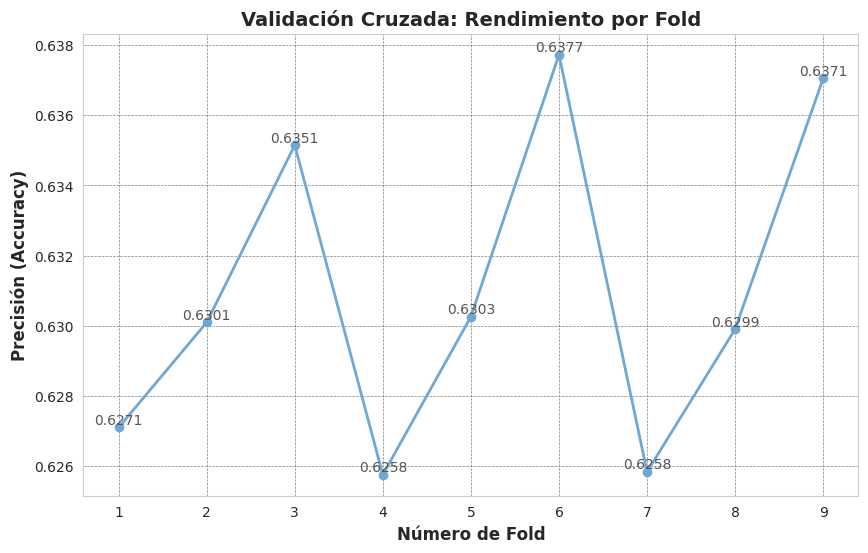

Número total de folds: 9
Número total de valores en scores: 9
El valor más alto es 0.6377298137713457 y está en la posición 6


In [62]:
folds = list(range(1, len(scores) + 1))
scores = cv_model.avgMetrics  # Lista de métricas obtenidas en cada pliegue


# Crear la gráfica mejorada con colores más suaves
plt.figure(figsize=(10,6))  # Tamaño más amplio para mejor visualización
plt.plot(folds, scores, marker='o', linestyle='-', color='#6EA8D3', linewidth=2)  # Azul tenue

# Agregar detalles importantes
plt.xlabel('Número de Fold', fontsize=12, fontweight='bold')
plt.ylabel('Precisión (Accuracy)', fontsize=12, fontweight='bold')
plt.title('Validación Cruzada: Rendimiento por Fold', fontsize=14, fontweight='bold')

# Activar cuadrícula con más suavidad
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Agregar anotaciones con color más neutro
for i, score in enumerate(scores):
    plt.text(folds[i], score, f'{score:.4f}', fontsize=10, ha='center', va='bottom', color='#555555')  # Gris oscuro

# Mostrar la gráfica mejorada
plt.show()

indice_max = scores.index(max(scores))
valor_mas_alto = max(scores)

print(f"Número total de folds: {len(folds)}")
print(f"Número total de valores en scores: {len(scores)}")
print(f"El valor más alto es {valor_mas_alto} y está en la posición {indice_max + 1}")



In [47]:
# 📌 Obtener el mejor modelo entrenado a partir de la validación cruzada
# Esto devuelve el modelo con los mejores hiperparámetros según la métrica de evaluación (Accuracy en este caso).
parametros = cv_model.bestModel

# 🔍 Extraer los hiperparámetros optimizados del mejor modelo encontrado
num_trees = parametros.getNumTrees  # 🌲 Número de árboles en el Random Forest
max_depth = parametros.getOrDefault("maxDepth")  # 📏 Profundidad máxima de los árboles (afecta la complejidad del modelo)
feature_subset_strategy = parametros.getOrDefault("featureSubsetStrategy")  # 🔎 Estrategia de selección de características en cada árbol
impurity = parametros.getOrDefault("impurity")  # ⚖ Criterio de impureza usado para dividir nodos
subsampling_rate = parametros.getOrDefault("subsamplingRate")  # 📉 Proporción de datos usados en cada árbol (permite evitar sobreajuste)

# 🚀 Realizar predicciones en el conjunto de prueba con el mejor modelo entrenado
predictions = cv_model.transform(test_data_stratum)

# 📊 Evaluar el rendimiento del mejor modelo usando Accuracy
mejor_acc = accuracy.evaluate(predictions)

# 🖨️ Imprimir los hiperparámetros optimizados
print(f"""📌 **Hiperparámetros del mejor modelo**
🌲 Número de árboles: \033[36m{num_trees}\033[0m
📏 Profundidad máxima: \033[36m{max_depth}\033[0m
🔎 Estrategia de selección de características: \033[36m{feature_subset_strategy}\033[0m
⚖ Criterio de impureza: \033[36m{impurity}\033[0m
📉 Tasa de muestreo: \033[36m{subsampling_rate}\033[0m""")

📌 **Hiperparámetros del mejor modelo**
🌲 Número de árboles: 50
📏 Profundidad máxima: 15
🔎 Estrategia de selección de características: auto
⚖ Criterio de impureza: entropy
📉 Tasa de muestreo: 1.0


In [48]:
# 🌳 Definición del modelo Random Forest Classifier
# Se establece el modelo con los mejores hiperparámetros obtenidos
# mediante validación cruzada, optimizando su rendimiento.
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='label',
    numTrees=num_trees,
    maxDepth=max_depth,
    featureSubsetStrategy= feature_subset_strategy ,
    impurity= impurity,
    subsamplingRate= subsampling_rate
)

In [49]:
# 🏋️ Entrenar el modelo con el conjunto de entrenamiento
rf_model_estratificado = rf.fit(train_data_stratum)

# **4 - Resultados**

In [61]:
# 📊 Evaluación del rendimiento del modelo en los diferentes métodos de muestreo

# 🎯 Calcular Accuracy (precisión global)
# Se evalúa qué porcentaje de predicciones fueron correctas en el conjunto de prueba.
accuracy_estratificado = accuracy.evaluate(rf_model_estratificado.transform(train_data_stratum))

# 🔍 Calcular Precision (qué tan exactas son las predicciones positivas)
# Se mide cuántos positivos predichos realmente lo son, evitando falsos positivos.
precision_estratificado = precision.evaluate(rf_model_estratificado.transform(train_data_stratum))

# 🚀 Calcular Recall (qué tan bien se identifican los positivos)
# Se mide cuántos positivos reales fueron correctamente identificados, evitando falsos negativos.
recall_estratificado = recall.evaluate(rf_model_estratificado.transform(train_data_stratum))

# ⚖ Calcular F1-Score (balance entre precisión y recall)
# Combina precisión y recall en una sola métrica para evaluar el desempeño del modelo.
f1_score_estratificado = f1_score.evaluate(rf_model_estratificado.transform(train_data_stratum))

# 📊 Imprimir los resultados comparando muestreo aleatorio y estratificado
print("\n🔎 Evaluación del Modelo - Comparación de Muestreos 🔍\n")

# 🎯 Accuracy
print(f"✅ Accuracy - Muestreo Estratificado: \033[36m{accuracy_estratificado:.4f}\033[0m 🎯")

# 🎯 Precision
print(f"🎯 Precisión - Muestreo Estratificado: \033[36m{precision_estratificado:.4f}\033[0m 🔍")

# 🔥 Recall
print(f"🔥 Recall - Muestreo Estratificado: \033[36m{recall_estratificado:.4f}\033[0m 🚀")

# ⚡ F1-Score
print(f"⚡ F1-Score - Muestreo Estratificado: \033[36m{f1_score_estratificado:.4f}\033[0m ⚖")



🔎 Evaluación del Modelo - Comparación de Muestreos 🔍

✅ Accuracy - Muestreo Estratificado: 0.6503 🎯
🎯 Precisión - Muestreo Estratificado: 0.7011 🔍
🔥 Recall - Muestreo Estratificado: 0.6503 🚀
⚡ F1-Score - Muestreo Estratificado: 0.6266 ⚖


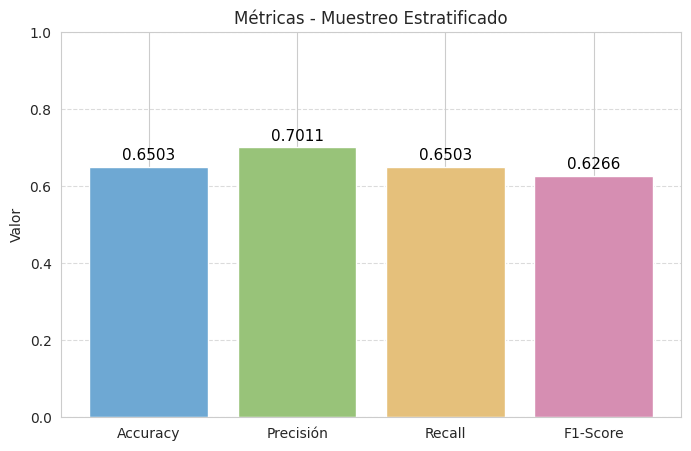

In [76]:
import matplotlib.pyplot as plt

# Nombres de las métricas y sus valores
metricas = ['Accuracy', 'Precisión', 'Recall', 'F1-Score']
valores = [accuracy_estratificado, precision_estratificado, recall_estratificado, f1_score_estratificado]

# Colores personalizados suaves
colores = ['#6EA8D3', '#98C379', '#E5C07B', '#D68EB2']

# Crear la gráfica
plt.figure(figsize=(8,5))
barras = plt.bar(metricas, valores, color=colores)

# Agregar valores encima de cada barra
for barra, valor in zip(barras, valores):
    plt.text(barra.get_x() + barra.get_width() / 2, valor + 0.01, f'{valor:.4f}',
             ha='center', va='bottom', fontsize=11, color='black')

# Etiquetas y título
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('Métricas - Muestreo Estratificado')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# **5 - Discusión y conclusiones**